In [1]:
#Imports
import pandas as pd
import csv
from api_keys import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [2]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [3]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop","Description"
                                ]]
reduced_traffic_df.shape

(7728394, 25)

In [5]:
#Using function to parse date and convert to strint
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [6]:
reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)

/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/4217142928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/4217142928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)


In [7]:
#using function to extract Year from date
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [8]:
reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)

/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3843608378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3843608378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)


In [9]:
#dropping NA from df
drop_traffic_df = reduced_traffic_df.dropna(how='any')
drop_traffic_df.shape

(5382749, 29)

In [10]:
#Using function to format the drop traffic dataframe
drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)
drop_traffic_df.shape

/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3689601372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3689601372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3689601372.py:4: SettingWith

(5382749, 29)

In [11]:
#reorganizing columns
organized_traffic_df = reduced_traffic_df[["Start_Year","Start_Date","End_Year","End_Date","Start_Time","End_Time",\
                                        "Severity","City","State","Weather_Condition","Temperature(F)","Visibility(mi)",\
                                        "Wind_Speed(mph)","Precipitation(in)","Sunrise_Sunset","Description","Bump",\
                                        "Crossing", "Give_Way","Junction","No_Exit","Railway","Roundabout","Station",\
                                        "Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]]
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,False,True,False
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,True,False


In [12]:
organized_traffic_gp = organized_traffic_df.groupby(["Start_Year"]).count()
organized_traffic_gp

,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Start_Year,,,,,,,,,,,,,,,,,,,,,
2016,410821,410821,410821,410821,410821,410821,410794,410821,402264,404372,...,410821,410821,410821,410821,410821,410821,410821,410821,410821,410821
2017,718093,718093,718093,718093,718093,718093,718066,718093,700543,703703,...,718093,718093,718093,718093,718093,718093,718093,718093,718093,718093
2018,893426,893426,893426,893426,893426,893426,893416,893426,871904,875415,...,893426,893426,893426,893426,893426,893426,893426,893426,893426,893426
2019,954303,954303,954303,954303,954303,954303,954284,954303,936077,937178,...,954303,954303,954303,954303,954303,954303,954303,954303,954303,954303
2020,1178913,1178913,1178913,1178913,1178913,1178913,1178863,1178913,1148939,1147949,...,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913
2021,1563753,1563753,1563753,1563753,1563753,1563753,1563700,1563753,1531440,1531731,...,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753
2022,1762452,1762452,1762452,1762452,1762452,1762452,1762387,1762452,1723764,1723734,...,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452
2023,246633,246633,246633,246633,246633,246633,246631,246633,240004,240459,...,246633,246633,246633,246633,246633,246633,246633,246633,246633,246633


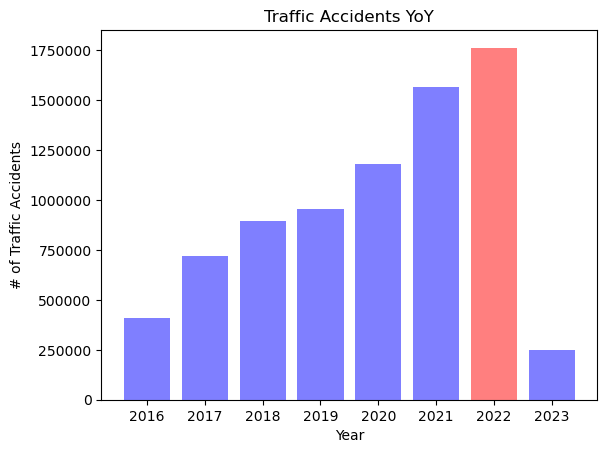

In [13]:
x_axis=organized_traffic_gp.index.tolist()
y_axis = organized_traffic_gp["State"].tolist()

plt.ticklabel_format(style='plain')
plt.bar(x_axis, y_axis,color=['b','b','b','b','b','b','r','b'],alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/AccidentsYoY.png")
plt.show()

In [14]:
day_v_night = organized_traffic_df.groupby(["Start_Year","Sunrise_Sunset"]).count().reset_index()

day_series = day_v_night["Sunrise_Sunset"] == "Day"
night_series = day_v_night["Sunrise_Sunset"] == "Night"

In [15]:
day_df = day_v_night.loc[day_series]
day_count= day_df[["Start_Year","State"]]
day_count_r = day_count.rename(columns={"State":"Day_Count"})

night_df = day_v_night.loc[night_series]
night_count= night_df[["Start_Year","State"]]
night_count_r = night_count.rename(columns={"State":"Night_Count"})

day_night_df = pd.merge(night_count_r,day_count_r,on="Start_Year")

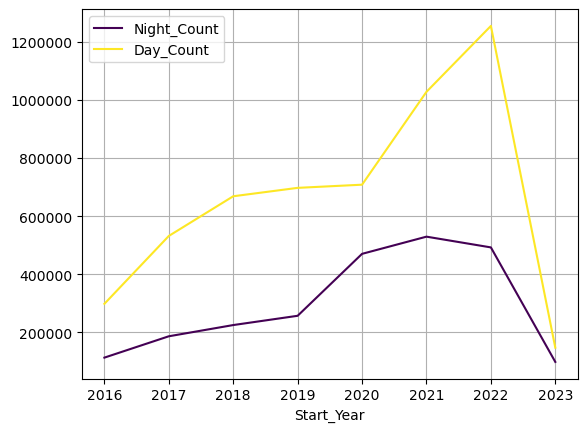

In [16]:
day_night_df.plot(x="Start_Year",kind="line",grid=True,colormap='viridis')
plt.ticklabel_format(style='plain')

plt.savefig("outputs/NigthtvDay.png")
plt.show()

In [17]:
#Adding total accidents to DF
total_accident = day_night_df[["Night_Count","Day_Count"]].sum(axis=1)
day_night_df["Total_Count"] = total_accident

In [18]:
#adding percentage of night v. day accidents
day_percent = (day_night_df["Day_Count"]/day_night_df["Total_Count"]) * 100
night_percent = (day_night_df["Night_Count"]/day_night_df["Total_Count"]) * 100

day_night_df["Night_Pct"] = night_percent
day_night_df["Day_Pct"] = day_percent

day_night_df

,Start_Year,Night_Count,Day_Count,Total_Count,Night_Pct,Day_Pct
0,2016,112742,298048,410790,27.445167,72.554833
1,2017,186263,531794,718057,25.939863,74.060137
2,2018,224905,668504,893409,25.173801,74.826199
3,2019,256833,697447,954280,26.913799,73.086201
4,2020,470174,708362,1178536,39.894751,60.105249
5,2021,529367,1028195,1557562,33.986897,66.013103
6,2022,492367,1255189,1747556,28.174605,71.825395
7,2023,97944,147014,244958,39.983997,60.016003


In [19]:
#Calling Census API
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"
json_url = requests.get(api_url).json()
print(api_url)

https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*&key=9adc74e4cfc4d4a300ce521d201d867bcab7e31a


In [20]:
#Creating DataFrame from API
api_df = pd.DataFrame(json_url)
api_df

,0,1,2,3
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [21]:
#renaming column headers
api_df.columns=["City","Population","State #","Place #"]

In [22]:
#drop original column
drop = api_df.drop([0,0])

In [23]:
#Splitting City and State
split_cl = drop["City"].str.split(',',expand=True)

In [24]:
#Renaming Column Header
split_cl.columns=["City_1","State",""]
split_cl

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [25]:
df =pd.concat([drop,split_cl],axis=1)
drop_df = df.drop([""],axis=1)
drop_df.head()

,City,Population,State #,Place #,City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [26]:
#creating function to trim spaces
def trim(raw):
    trim = raw.strip()
    return trim

In [27]:
#Trimming space on State Column
drop_df["State"]= drop_df["State"].map(trim)

In [28]:
#renaming columns
census_rename_df = drop_df.rename(columns={"City":"City_State","City_1":"City"})
census_rename_df.head()

,City_State,Population,State #,Place #,City,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [29]:
#reordering columns
organized_census_df = census_rename_df[["City","State","Population","State #","Place #","City_State" 
]]
organized_census_df.head()

,City,State,Population,State #,Place #,City_State
1,Abanda CDP,Alabama,231,01,00100,"Abanda CDP, Alabama"
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
4,Addison town,Alabama,697,01,00484,"Addison town, Alabama"
5,Akron town,Alabama,385,01,00676,"Akron town, Alabama"


In [30]:
#Pulling City and excluding Puerto Rico
census_clean_df = organized_census_df[(organized_census_df["City"].str.contains("city")) \
                                      & (organized_census_df["State"] != "Puerto Rico")]
census_clean_df

,City,State,Population,State #,Place #,City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [31]:
#converting population to integer
census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)

/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/243609777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)
/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/243609777.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)


In [32]:
#Function to strip "city" from City
def strip(raw):
    city = raw.strip("city")
    trim = city.strip()
    return trim

In [33]:
census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)

/var/folders/ny/ymyn74hj6y5g_ptbcv3wyqdh0000gn/T/ipykernel_8167/3544217579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)


In [34]:
city_rename = census_clean_df.rename(columns={"City": "City1","City2": "City"})
city_rename

,City1,State,Population,State #,Place #,City_State,City
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington


In [35]:
#importing City and State abbrev.
crosswalk_path = "Resources/crosswalk.csv"
state_abv = pd.read_csv(crosswalk_path)

In [36]:
#merging abbriviation data to census
crosswalk_state = pd.merge(city_rename,state_abv,on="State")

In [37]:
rename_cross = crosswalk_state.rename(columns={"State":"State_old","Abbreviation":"State"})
rename_cross.head()

,City1,State_old,Population,State #,Place #,City_State,City,State
0,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville,AL
1,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville,AL
2,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster,AL
3,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville,AL
4,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City,AL


In [38]:
sorted_og_traffic = organized_traffic_df.sort_values(by=["State","City"],ascending=True)
sorted_og_traffic.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
523666,2022,2022-08-27,2022,2022-08-27,2022-08-27 14:47:41,2022-08-27 15:17:20,2,Abbeville,AL,Thunder in the Vicinity,...,True,False,False,False,False,False,False,False,False,False
530035,2022,2022-08-20,2022,2022-08-20,2022-08-20 16:32:02,2022-08-20 17:01:44,2,Abbeville,AL,Fair,...,False,False,False,False,False,False,False,False,False,False
536021,2022,2022-08-12,2022,2022-08-12,2022-08-12 20:30:17,2022-08-12 21:19:12,1,Abbeville,AL,Fair,...,True,False,False,False,False,False,False,False,False,False
548951,2022,2022-07-29,2022,2022-07-29,2022-07-29 06:38:49,2022-07-29 07:38:24,2,Abbeville,AL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
557220,2022,2022-07-20,2022,2022-07-20,2022-07-20 12:57:22,2022-07-20 13:40:00,2,Abbeville,AL,Partly Cloudy,...,False,False,False,False,False,False,False,False,False,False


In [39]:
state_accidents = sorted_og_traffic.groupby(["Start_Year","State","City"]).count()

In [40]:
#resetting index on state_accidents
clean_reset_df = state_accidents.reset_index()
clean_reset_df

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2016,AL,Athens,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2016,AL,Atmore,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,2016,AL,Attalla,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2016,AL,Auburn,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97722,2023,WY,Rock Springs,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
97723,2023,WY,Sinclair,36,36,36,36,36,36,33,...,36,36,36,36,36,36,36,36,36,36
97724,2023,WY,Wamsutter,77,77,77,77,77,77,29,...,77,77,77,77,77,77,77,77,77,77
97725,2023,WY,Wheatland,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [41]:
#merging Census and City Traffic data
state_city_accident_census = pd.merge(clean_reset_df,rename_cross,on=["State","City"],how="inner")
state_city_accident_census

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,City1,State_old,Population,State #,Place #,City_State
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
1,2018,AL,Ashville,11,11,11,11,11,11,11,...,11,11,11,11,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
2,2019,AL,Ashville,8,8,8,8,8,8,8,...,8,8,8,8,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
3,2020,AL,Ashville,7,7,7,7,7,7,7,...,7,7,7,7,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
4,2021,AL,Ashville,18,18,18,18,18,18,15,...,18,18,18,18,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2023,TX,Talco,1,1,1,1,1,1,1,...,1,1,1,1,Talco city,Texas,577,48,71732,"Talco city, Texas"
36920,2023,TX,Trenton,3,3,3,3,3,3,3,...,3,3,3,3,Trenton city,Texas,729,48,73592,"Trenton city, Texas"
36921,2023,WV,Follansbee,1,1,1,1,1,1,1,...,1,1,1,1,Follansbee city,West Virginia,2842,54,28204,"Follansbee city, West Virginia"
36922,2023,WV,McMechen,1,1,1,1,1,1,1,...,1,1,1,1,McMechen city,West Virginia,1667,54,50260,"McMechen city, West Virginia"


In [42]:
#simplifying columns
city_accident_census = state_city_accident_census[["State","City","Start_Year","Population","Start_Date"]]
city_accident_census.head()

,State,City,Start_Year,Population,Start_Date
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18


In [43]:
#merging census and traffic data
census_traffic_df = pd.merge(reduced_traffic_df,rename_cross,on=["State","City"],how="inner")
census_traffic_df.head()

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
1,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
2,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
3,2016-02-08 07:59:35,2016-02-08 08:29:35,2,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
4,2016-02-08 07:59:58,2016-02-08 08:29:58,3,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"


In [44]:
#renaming colums
census_accidents_pop =city_accident_census.rename(columns={"Start_Date":"Accidents"})
census_accidents_pop

,State,City,Start_Year,Population,Accidents
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18
...,...,...,...,...,...
36919,TX,Talco,2023,577,1
36920,TX,Trenton,2023,729,3
36921,WV,Follansbee,2023,2842,1
36922,WV,McMechen,2023,1667,1


In [45]:
#Population per 100K
census_accidents_pop["pop_per_100K"] = census_accidents_pop["Population"]/100000
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K
0,AL,Ashville,2016,2096,1,0.02096
1,AL,Ashville,2018,2096,11,0.02096
2,AL,Ashville,2019,2096,8,0.02096
3,AL,Ashville,2020,2096,7,0.02096
4,AL,Ashville,2021,2096,18,0.02096
...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577
36920,TX,Trenton,2023,729,3,0.00729
36921,WV,Follansbee,2023,2842,1,0.02842
36922,WV,McMechen,2023,1667,1,0.01667


In [46]:
#accidents per 100K population
census_accidents_pop["accidents_per_pop_100K"] = census_accidents_pop["Accidents"] / census_accidents_pop["pop_per_100K"]
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,AL,Ashville,2016,2096,1,0.02096,47.709924
1,AL,Ashville,2018,2096,11,0.02096,524.809160
2,AL,Ashville,2019,2096,8,0.02096,381.679389
3,AL,Ashville,2020,2096,7,0.02096,333.969466
4,AL,Ashville,2021,2096,18,0.02096,858.778626
...,...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577,173.310225
36920,TX,Trenton,2023,729,3,0.00729,411.522634
36921,WV,Follansbee,2023,2842,1,0.02842,35.186488
36922,WV,McMechen,2023,1667,1,0.01667,59.988002


In [47]:
#fitering on population >100K
major_cities = census_accidents_pop[census_accidents_pop["Population"]>=100000]

In [48]:
major_cities.sort_values(by=["accidents_per_pop_100K"],ascending=False)

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
5112,FL,Miami,2022,440807,64505,4.40807,14633.388308
5111,FL,Miami,2021,440807,58816,4.40807,13342.800818
5317,FL,Orlando,2022,302968,36402,3.02968,12015.130311
5316,FL,Orlando,2021,302968,33014,3.02968,10896.860394
11119,LA,Baton Rouge,2021,225539,14552,2.25539,6452.099193
...,...,...,...,...,...,...,...
20377,TX,Amarillo,2016,200371,1,2.00371,0.499074
264,AR,Little Rock,2016,201893,1,2.01893,0.495312
31833,FL,Port St. Lucie,2018,202177,1,2.02177,0.494616
30516,TX,Lubbock,2023,255537,1,2.55537,0.391333


In [49]:
 major_cities["accidents_per_pop_100K"]*major_cities["pop_per_100K"]- major_cities["Accidents"]


37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
        ... 
35633    0.0
35713    0.0
35714    0.0
35715    0.0
35716    0.0
Length: 2327, dtype: float64

In [50]:
accident_by_city = major_cities.groupby(["Start_Year","State","City"])

accident_df = accident_by_city.first()
#accident_by_city.apply(display)
#accident_by_city.get_group((2022,"FL","Miami"))

In [51]:
accident_df.reset_index()

,Start_Year,State,City,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,2016,AL,Birmingham,202234,28,2.02234,13.845347
1,2016,AL,Mobile,187445,7,1.87445,3.734429
2,2016,AL,Montgomery,201022,13,2.01022,6.466954
3,2016,AR,Little Rock,201893,1,2.01893,0.495312
4,2016,AZ,Chandler,272439,85,2.72439,31.199645
...,...,...,...,...,...,...,...
2322,2023,WA,Tacoma,217332,149,2.17332,68.558703
2323,2023,WA,Vancouver,188331,88,1.88331,46.726243
2324,2023,WI,Green Bay,107083,59,1.07083,55.097448
2325,2023,WI,Madison,265447,188,2.65447,70.823931


In [52]:
# Author: Samin
FIRST_YEAR=2016
LAST_YEAR=2022
MIN_MAJOR_CITY_SIZE=100000

In [65]:
# Filter cities with a population over 100,000
major_cities = major_cities[major_cities['Population'] >= MIN_MAJOR_CITY_SIZE]

# DataFrame for traffic accidents in 2016 and 2022
accidents_2016 = major_cities[major_cities['Start_Year'] == FIRST_YEAR][['City','State', 'accidents_per_pop_100K']]
accidents_2022 = major_cities[major_cities['Start_Year'] == LAST_YEAR][['City','State', 'accidents_per_pop_100K']]

# Merge the two DataFrames to calculate the change in accidents
accidents_change = pd.merge(accidents_2016, accidents_2022, on=['State','City'], suffixes=('_2016', '_2022'))
accidents_change

,City,State,accidents_per_pop_100K_2016,accidents_per_pop_100K_2022
0,Birmingham,AL,13.845347,1573.424844
1,Mobile,AL,3.734429,519.619088
2,Montgomery,AL,6.466954,948.652386
3,Little Rock,AR,0.495312,638.457004
4,Chandler,AZ,31.199645,450.743102
...,...,...,...,...
276,Tacoma,WA,237.424769,581.598660
277,Vancouver,WA,48.319183,303.189597
278,Green Bay,WI,15.875536,91.517795
279,Madison,WI,42.946426,332.646442


In [66]:
accidents_change['Change'] =((accidents_change['accidents_per_pop_100K_2022'] - accidents_change['accidents_per_pop_100K_2016'])/accidents_change['accidents_per_pop_100K_2016'])
accidents_change.sort_values(by='Change',ascending=True)

,City,State,accidents_per_pop_100K_2016,accidents_per_pop_100K_2022,Change
183,Omaha,NE,987.790411,175.798418,-0.822029
131,Elgin,IL,680.647535,232.138477,-0.658945
257,Waco,TX,35.818713,13.157895,-0.632653
275,Spokane Valley,WA,69.486582,27.403159,-0.605634
156,Springfield,MA,22.469025,9.629582,-0.571429
...,...,...,...,...,...
207,Tulsa,OK,10.471153,1578.465465,149.744186
256,Tyler,TX,7.623041,1624.660536,212.125000
173,Billings,MT,2.593159,638.781561,245.333333
171,Springfield,MO,4.744874,1529.035664,321.250000


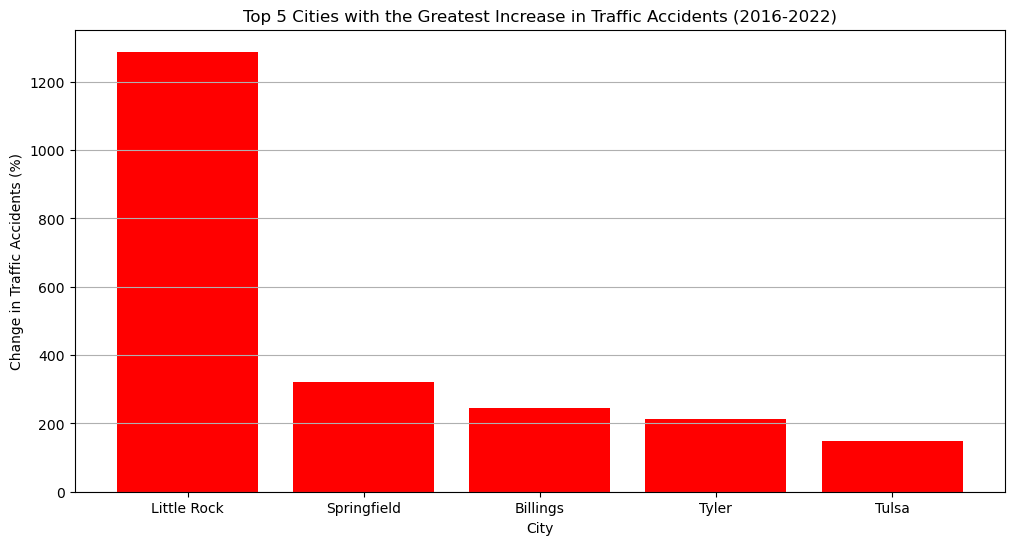

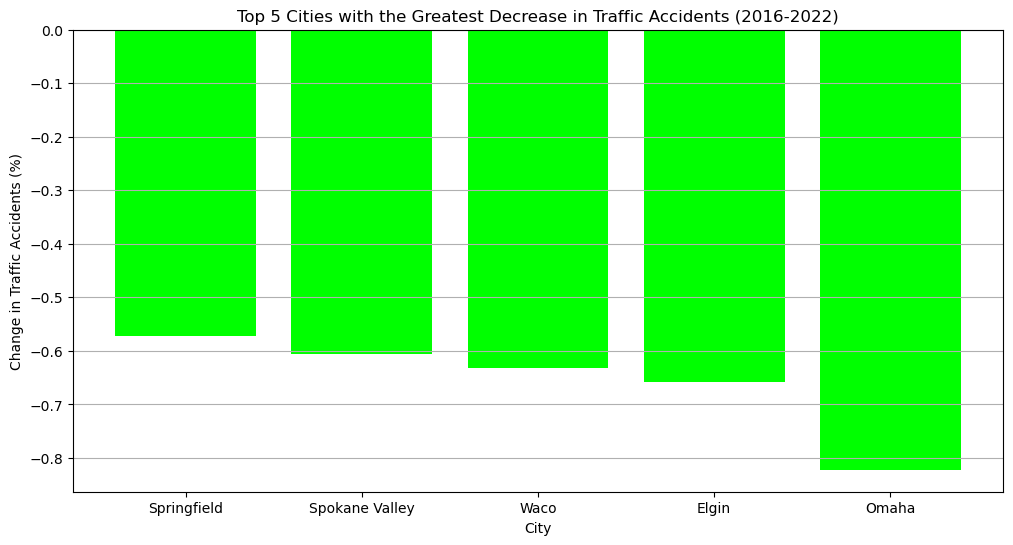

In [78]:
accidents_change = accidents_change.sort_values(by='Change', ascending=False)

# Get the top 5 cities with the greatest increase and decrease
top_increase_cities = accidents_change.head(5)
top_decrease_cities = accidents_change.tail(5)

# Define custom colors for bright red and bright green
bright_red = '#FF0000'
bright_green = '#00FF00'

# Create a bar chart for the cities with the greatest increase in traffic accidents
plt.figure(figsize=(12, 6))
plt.bar(top_increase_cities['City'], top_increase_cities['Change'], color=bright_red)
plt.xlabel('City')
plt.ylabel('Change in Traffic Accidents (%)')
plt.title('Top 5 Cities with the Greatest Increase in Traffic Accidents (2016-2022)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.savefig('greatest_increase_traffic_bar.png')
plt.show()

# Create a bar chart for the cities with the greatest decrease in traffic accidents
plt.figure(figsize=(12, 6))
plt.bar(top_decrease_cities['City'], top_decrease_cities['Change'], color=bright_green)
plt.xlabel('City')
plt.ylabel('Change in Traffic Accidents (%)')
plt.title('Top 5 Cities with the Greatest Decrease in Traffic Accidents (2016-2022)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.savefig('greatest_decrease_traffic_bar.png')
plt.show()